In [4]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import pandas as pd
from shapely.geometry import Polygon
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'errorbar.capsize': 2})

In [8]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    
    #return ax.add_patch(ellipse)
    return ellipse

def multiple_formatter(denominator=3, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\dfrac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\dfrac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\dfrac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter


class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

In [9]:
# IMPORT MAD-X FILES
# This assumes the tables were generated with ONETABLE

# The revolution frequency changes depending on the energy and layout of the ring
# ALWAYS CHECK REVOLUTION FREQUENCY OUTPUT FROM MAD-X
velc=2.99792458e8
f0=2.20964632e6*2*np.pi
psc=0.4197094412

# Check how many skiprows from BASISONE file 
data=pd.read_csv('basisone',comment='#',sep='\s+',skiprows=6,engine='python')

# Import the particles data
data_clean=data.shift(periods=1, axis='columns').drop([0]).drop(['*'],axis=1)
data_clean=data_clean.apply(pd.to_numeric)

# Add a new column with the phase of the particles using the revolution frequency
data_clean['PHASE']=np.mod(data_clean['T']*f0/velc+np.pi,2*np.pi)-np.pi

# Add a new column with the energy spread of the particles using the design momentum
data_clean['DELTAE']=data_clean['PT']*psc

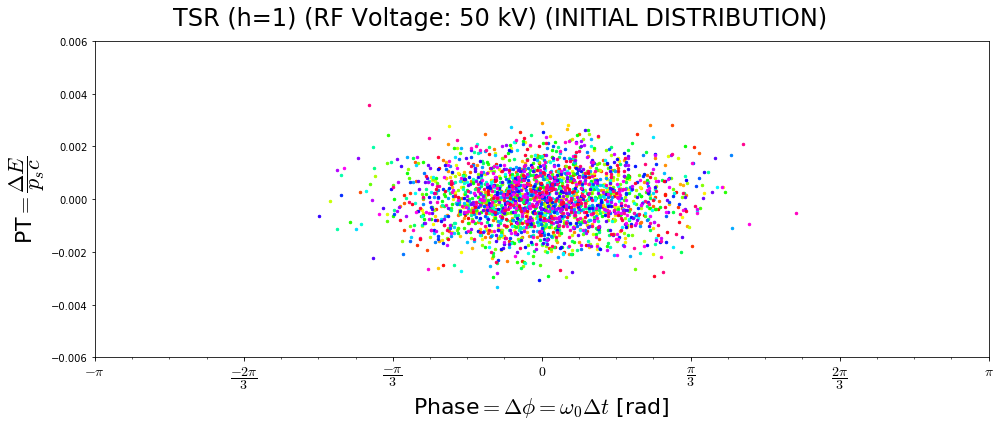

In [10]:
title1='TSR (h=1) (RF Voltage: 50 kV)'

particles=np.arange(data_clean['NUMBER'].min(),data_clean['NUMBER'].max()+1)

fig,ax=plt.subplots(1,1,figsize=(14,6))
plt.suptitle(title1+' (INITIAL DISTRIBUTION)',fontsize=24)

N = len(particles)
cmap = plt.cm.get_cmap("hsv", N+1)


for i in particles:
    df_plot=data_clean[np.multiply(data_clean['NUMBER']==i,data_clean['S']==0)]
    
    ax.scatter(df_plot['PHASE'],df_plot['PT'],s=6,color=cmap(i))
    
    ax.set_xlabel(r'Phase$=\Delta \phi= \omega_0 \Delta t $ [rad]',fontsize=22)
    ax.set_ylabel(r'PT$=\dfrac{\Delta E}{p_s c}$',fontsize=22)
    ax.set_ylim(-0.006,0.006)
    ax.set_xlim(-np.pi,np.pi)
    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 3))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.tick_params(axis='x', which='major', labelsize=14)
    
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()
plt.close()

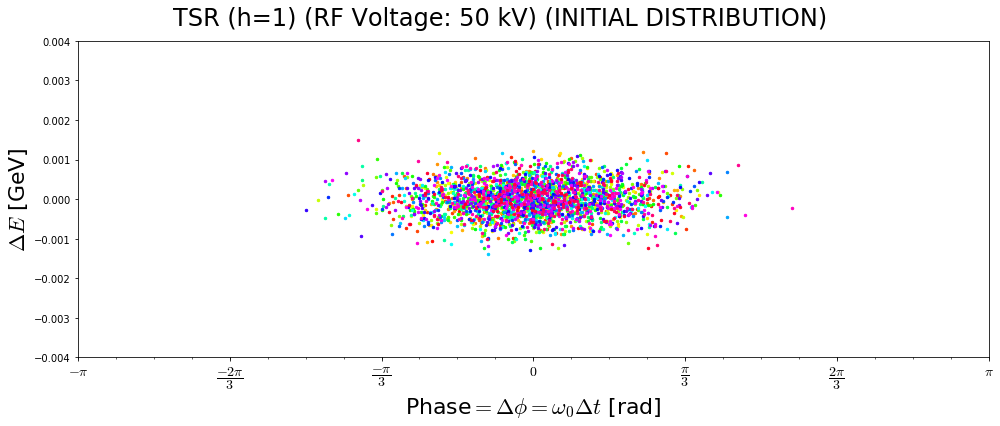

In [14]:
particles=np.arange(data_clean['NUMBER'].min(),data_clean['NUMBER'].max()+1)

fig,ax=plt.subplots(1,1,figsize=(14,6))
plt.suptitle(title1+' (INITIAL DISTRIBUTION)',fontsize=24)

N = len(particles)
cmap = plt.cm.get_cmap("hsv", N+1)


for i in particles:
    df_plot=data_clean[np.multiply(data_clean['NUMBER']==i,data_clean['S']==0)]
    
    ax.scatter(df_plot['PHASE'],df_plot['DELTAE'],s=6,color=cmap(i))
    
    ax.set_xlabel(r'Phase$=\Delta \phi= \omega_0 \Delta t $ [rad]',fontsize=22)
    ax.set_ylabel(r'$\Delta E $ [GeV]',fontsize=22)
    ax.set_ylim(-0.004,0.004)
    ax.set_xlim(-np.pi,np.pi)
    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 3))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.tick_params(axis='x', which='major', labelsize=14)
    
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()
plt.close()

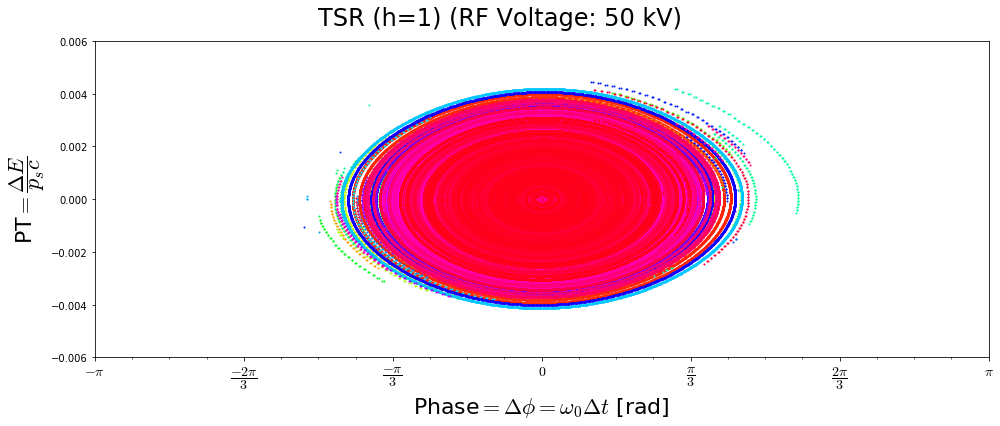

In [6]:
particles=np.arange(data_clean['NUMBER'].min(),data_clean['NUMBER'].max()+1)

fig,ax=plt.subplots(1,1,figsize=(14,6))
plt.suptitle(title1,fontsize=24)

N = len(particles)
cmap = plt.cm.get_cmap("hsv", N+1)

turns=np.arange(data_clean['TURN'].min(),5)

for i in particles:
    df_plot=data_clean[data_clean['NUMBER']==i]
    
    ax.scatter(df_plot['PHASE'],df_plot['PT'],s=1,color=cmap(i))
    
    ax.set_xlabel(r'Phase$=\Delta \phi= \omega_0 \Delta t $ [rad]',fontsize=22)
    ax.set_ylabel(r'PT$=\dfrac{\Delta E}{p_s c}$',fontsize=22)
    ax.set_ylim(-0.006,0.006)
    ax.set_xlim(-np.pi,np.pi)
    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 3))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.tick_params(axis='x', which='major', labelsize=14)
    
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()
plt.close()
    


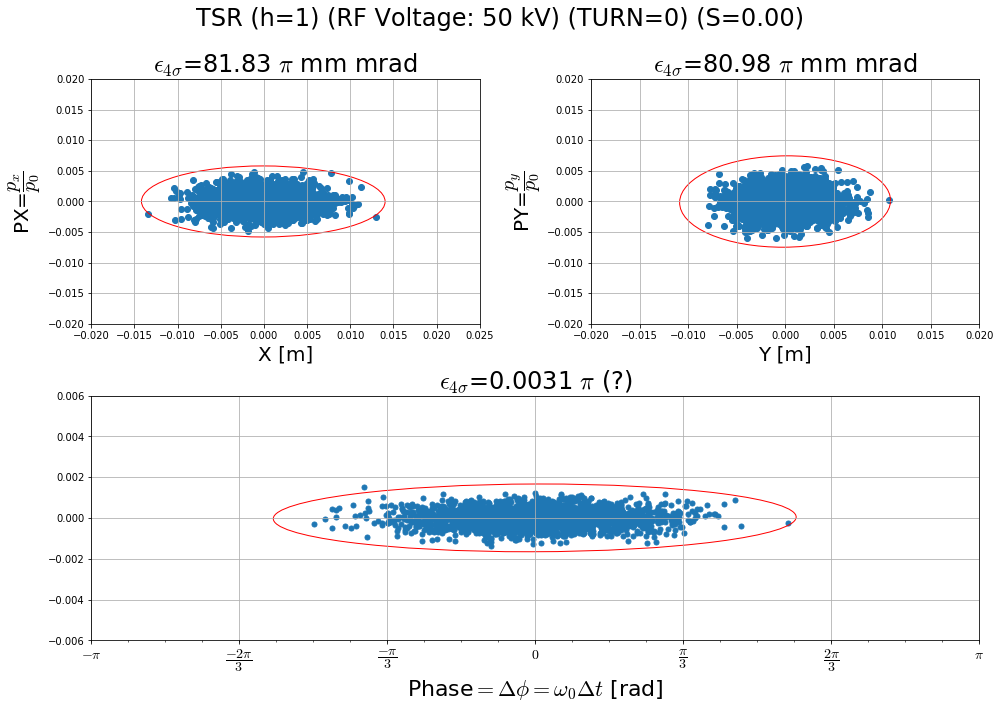

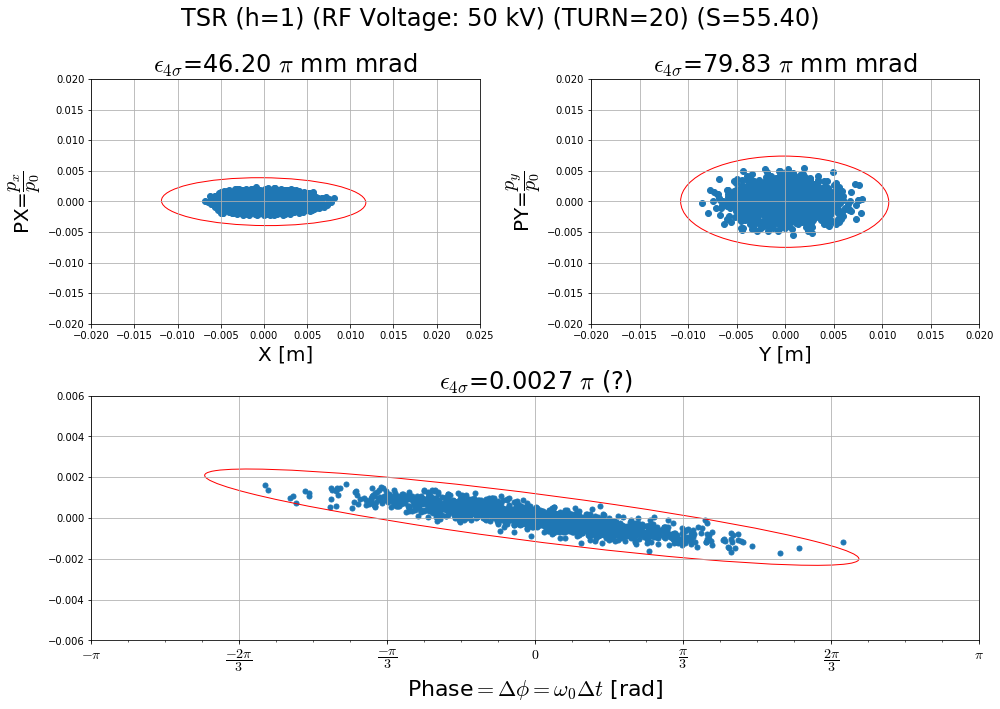

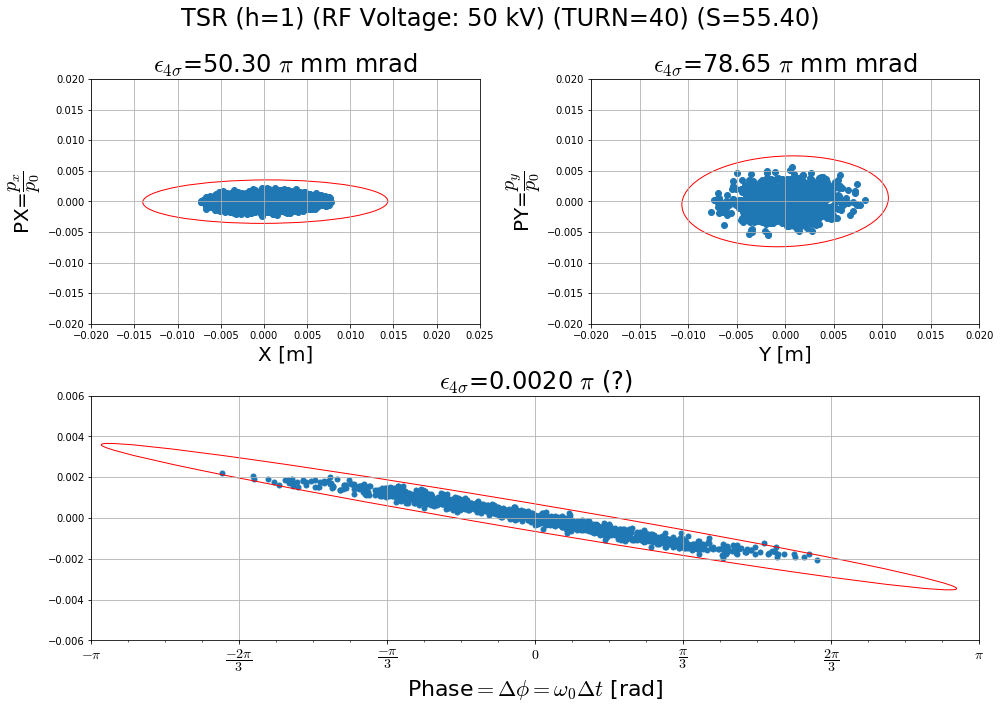

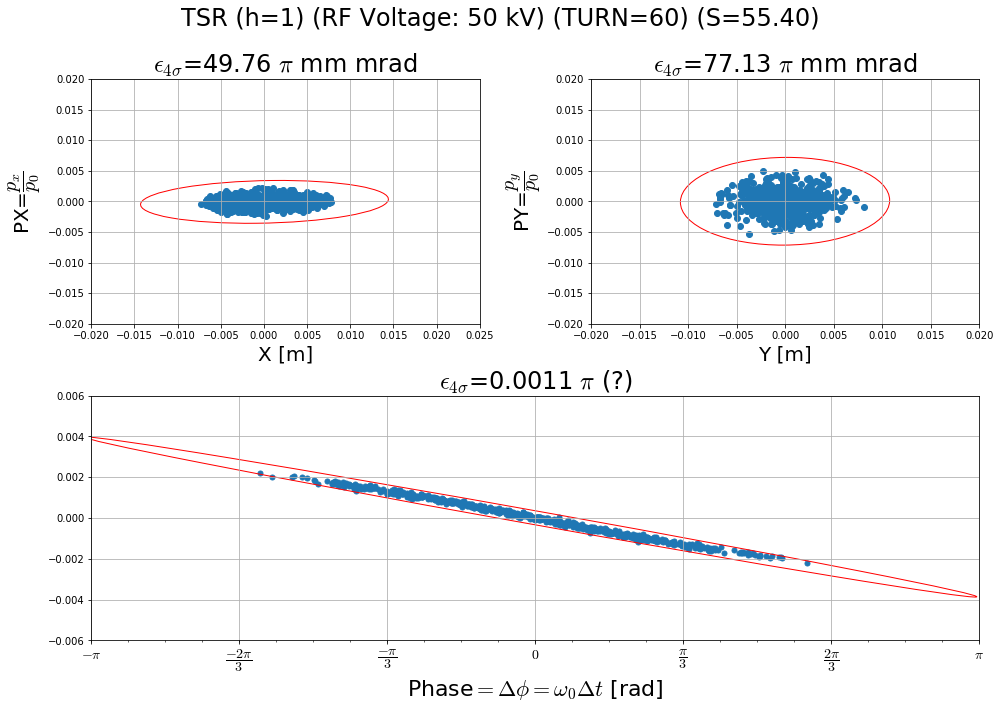

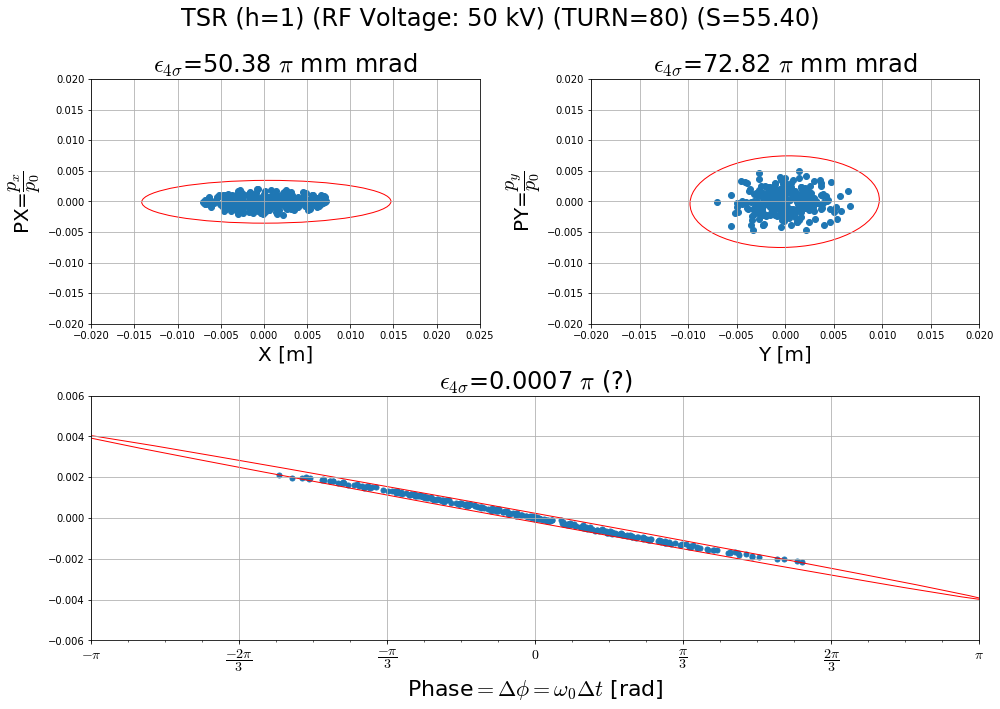

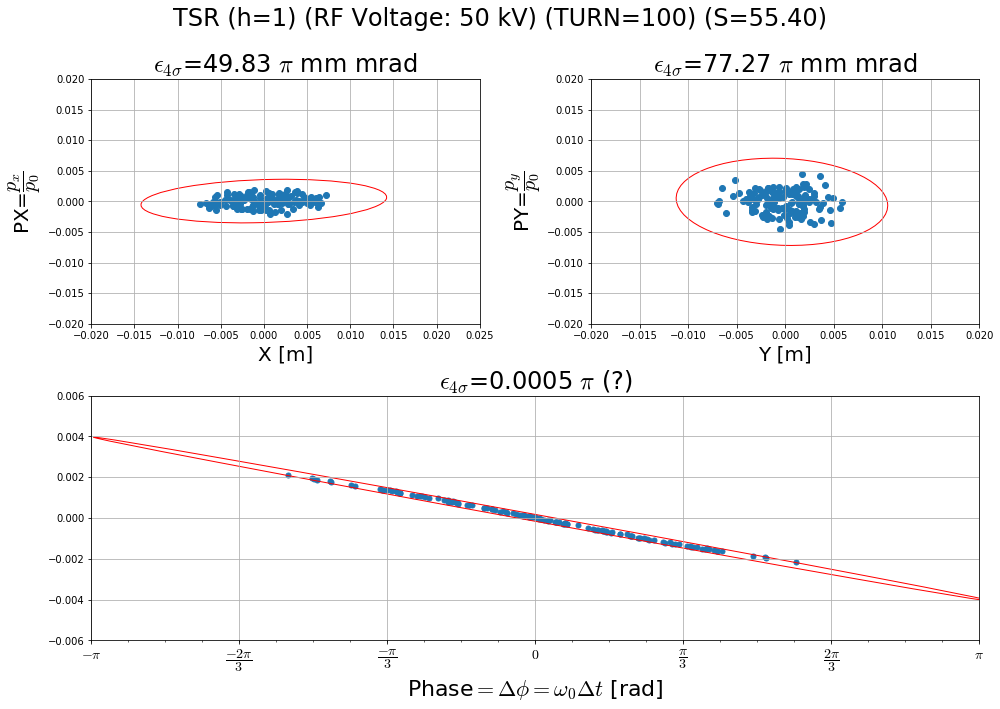

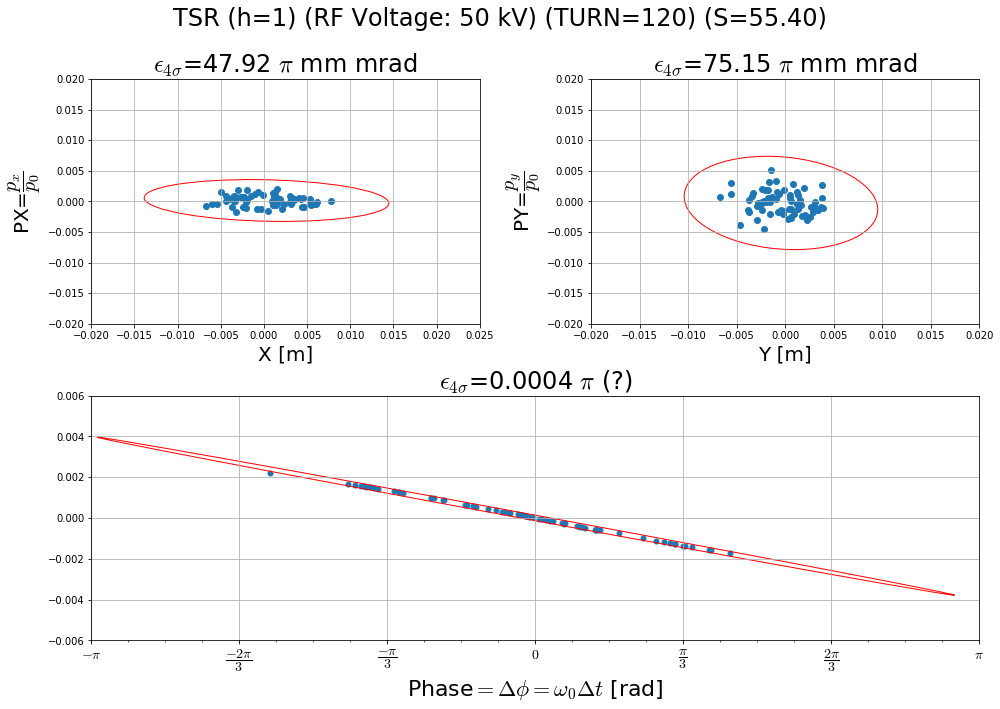

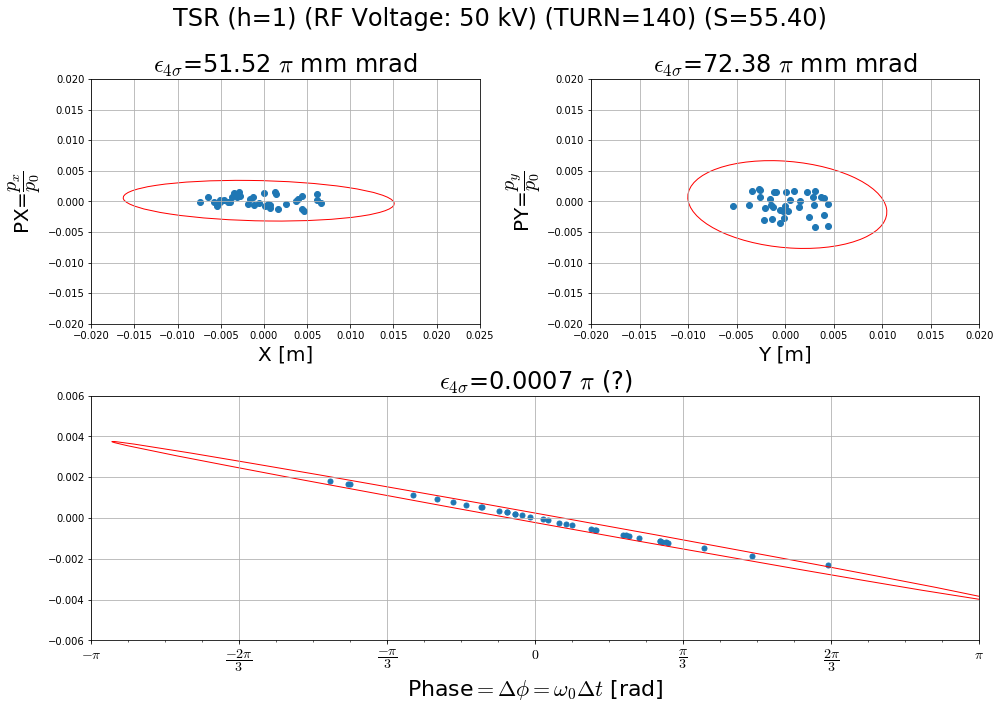

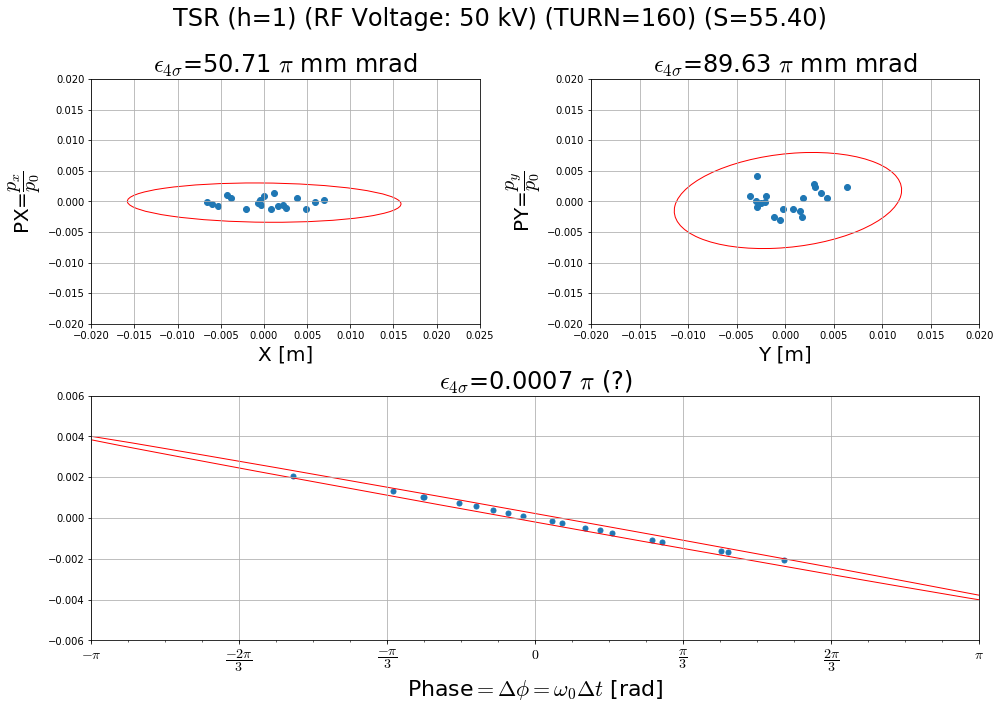

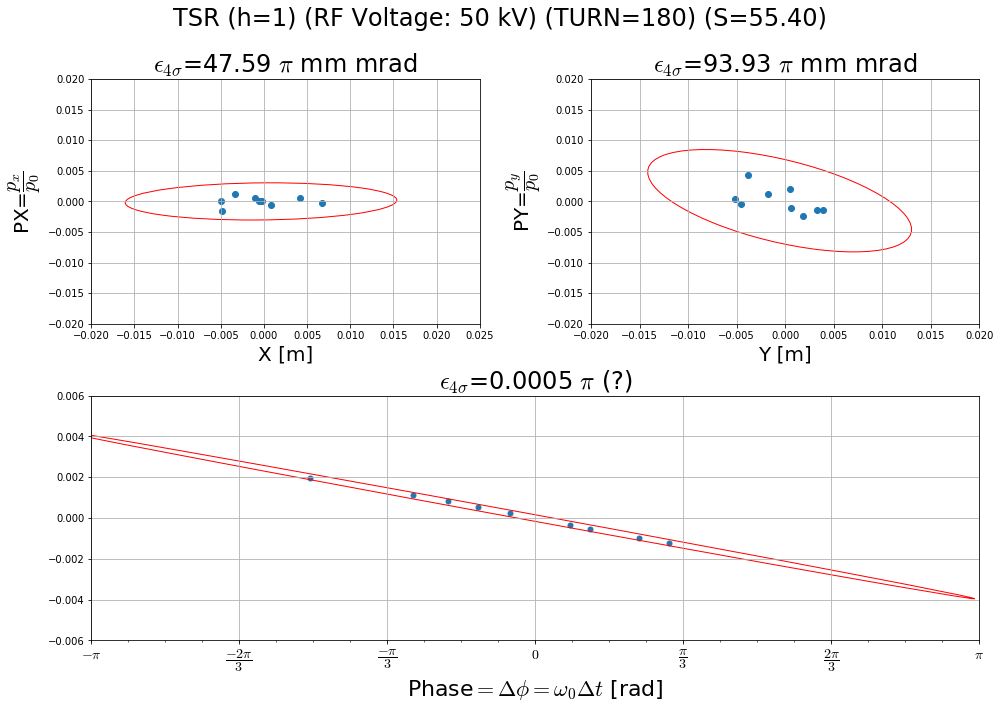

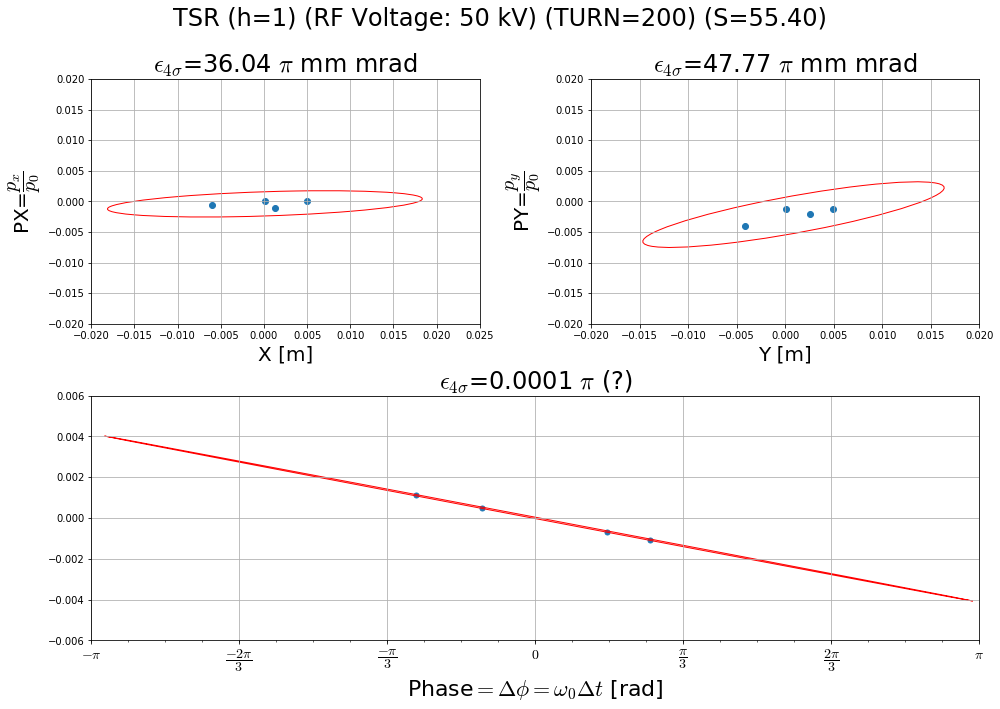

In [16]:
turns=np.linspace(0,200,11)

for i in turns:
    
    df_turn=data_clean[data_clean['TURN']==i]
    
    #s_values=np.unique(df_turn['S'])
    s_values=np.array([55.4])
    nsig=4
    
    gs = gridspec.GridSpec(2, 2)
    
    for s in s_values:
        
        df_plot=df_turn[df_turn['S']==s]
        
        if i==0:
            s=0
            df_plot=df_turn[df_turn['S']==0]
        
        fig=plt.figure(figsize=(14,10))
        
        plt.suptitle(title1+' (TURN=%i) (S=%.2f)'%(i,s),fontsize=24)
        
        # Create first plot of X phase space
        ax1=plt.subplot(gs[0, 0])
        ax1.scatter(df_plot['X'],df_plot['PX'])
        ax1.set_xlabel('X [m]',fontsize=20)
        ax1.set_ylabel(r'PX=$\dfrac{p_x}{p_0}$',fontsize=20)
        ax1.set_xlim(-0.02,0.025)
        ax1.set_ylim(-0.02,0.02)
        ax1.grid()
        
        elli1=confidence_ellipse(df_plot['X'],df_plot['PX'],ax1,n_std=nsig,edgecolor='red')
        ax1.add_patch(elli1)
        verts1=ax1.transData.inverted().transform(elli1.get_verts())
        poly1=Polygon(verts1)
        area1=poly1.area/np.pi
        ax1.set_title(r'$\epsilon_{%i \sigma}$=%.2f $\pi$ mm mrad'%(nsig,10**6*area1),fontsize=24)
        
        # Create second plot Y phase space
        ax2=plt.subplot(gs[0, 1])
        ax2.scatter(df_plot['Y'],df_plot['PY'])
        ax2.set_xlabel('Y [m]',fontsize=20)
        ax2.set_ylabel(r'PY=$\dfrac{p_y}{p_0}$',fontsize=20)
        ax2.set_xlim(-0.02,0.02)
        ax2.set_ylim(-0.02,0.02)
        ax2.grid()
        
        elli2=confidence_ellipse(df_plot['Y'],df_plot['PY'],ax2,n_std=nsig,edgecolor='red')
        ax2.add_patch(elli2)
        verts2=ax2.transData.inverted().transform(elli2.get_verts())
        poly2=Polygon(verts2)
        area2=poly2.area/np.pi
        ax2.set_title(r'$\epsilon_{%i \sigma}$=%.2f $\pi$ mm mrad'%(nsig,10**6*area2),fontsize=24)

        # Create third bigger plot of the energy-phase phase space 
        ax3=plt.subplot(gs[1, :])
        ax3.scatter(df_plot['PHASE'],df_plot['DELTAE'],s=25)
        ax3.set_xlabel(r'Phase$=\Delta \phi= \omega_0 \Delta t $ [rad]',fontsize=22)
        ax.set_ylabel(r'$\Delta E $ [GeV]',fontsize=22)
        ax3.set_ylim(-0.006,0.006)
        ax3.set_xlim(-np.pi,np.pi)
        ax3.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 3))
        ax3.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
        ax3.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        ax3.tick_params(axis='x', which='major', labelsize=14)
        ax3.grid()
        
        nsig3=4
        elli3=confidence_ellipse(df_plot['PHASE'],df_plot['DELTAE'],ax3,n_std=nsig3,edgecolor='red')
        ax3.add_patch(elli3)
        verts3=ax3.transData.inverted().transform(elli3.get_verts())
        poly3=Polygon(verts3)
        area3=poly3.area/np.pi
        ax3.set_title(r'$\epsilon_{%i \sigma}$=%.4f $\pi$ (?)'%(nsig3,area3),fontsize=24)
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.88)
        #fig.savefig('GIF/turn%is%i.png'%(i,s))
        plt.show()
        plt.close()
    

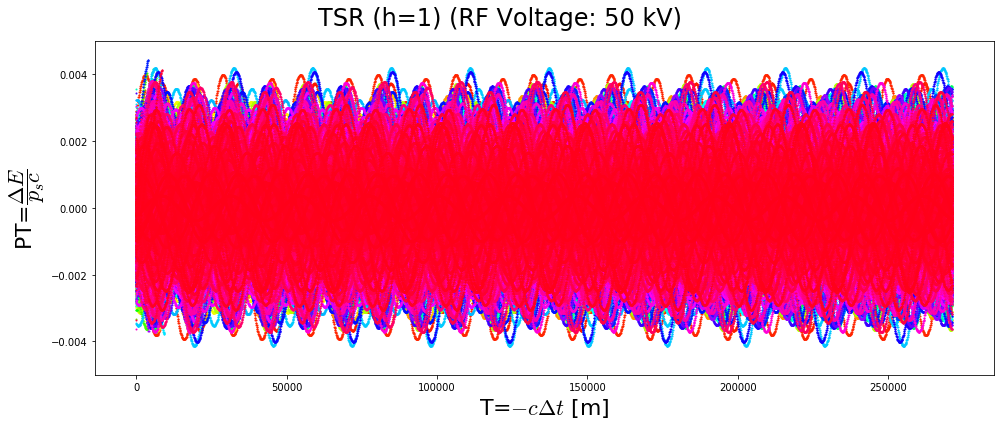

In [21]:
particles=np.arange(data_clean['NUMBER'].min(),data_clean['NUMBER'].max()+1)
df_plot=data_clean

fig,ax=plt.subplots(1,1,figsize=(14,6))
plt.suptitle(title1,fontsize=24)

N = len(particles)
cmap = plt.cm.get_cmap("hsv", N+1)

for i in particles:
    df_plot=data_clean[data_clean['NUMBER']==i]
    
    ax.scatter(df_plot['T'],df_plot['PT'],s=1,color=cmap(i))
    
    ax.set_xlabel(r'T=$-c \Delta t$ [m]',fontsize=22)
    ax.set_ylabel(r'PT=$\dfrac{\Delta E}{p_s c}$',fontsize=22)
    ax.set_ylim(-0.005,0.005)
    
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()
plt.close()
   